In [1]:
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
unique_model_names = glob.glob('O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\new_bc\\FINAL_MODELS\\*.nc')

In [3]:
unique_model_names

['O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\new_bc\\FINAL_MODELS\\EUR-11_ICHEC-EC-EARTH_rcp85_r12i1p1_MOHC-HadREM3-GA7-05_1952-1952_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\new_bc\\FINAL_MODELS\\EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1_CNRM-ALADIN63_1951-1951_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\new_bc\\FINAL_MODELS\\EUR-11_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_DMI-HIRHAM5_1951-1951_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\new_bc\\FINAL_MODELS\\EUR-11_MOHC-HadGEM2-ES_rcp85_r1i1p1_DMI-HIRHAM5_1951-2099_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\new_bc\\FINAL_MODELS\\EUR-11_CCCma-CanESM2_rcp85_r1i1p1_CLMcom-CCLM4-8-17_1951-1951_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Klimaatlas_CORDEX\\raw data\\new_bc\\FINAL_MODELS\\EUR-11_MIROC-MIROC5_rcp85_r

In [4]:
len(unique_model_names)

31

In [5]:
# Define your latitude and longitude bounds
#lat_min, lat_max = 55.38, 55.75
#lon_min, lon_max = 8.15, 9.13

In [9]:
%%time
for model in list(unique_model_names):
    
    #Select corresponding GCM model name 
    model_name = re.search(r'11_(.*?)_rcp', model)
    model_name = model_name.group(1)
    print(model_name)
    
    #Select RCM model name 
    rcm_model_name = model.split('_')[-4]
    print(rcm_model_name)

    #Select corresponding GCM model run string 
    model_run = re.search(r'85_(.*?)_', model)
    model_run = model_run.group(1)
    print(model_run)
    
    #Pathway to GMST 
    GMST_file_path = glob.glob(f"O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\CMIP5 GCM Data\\GMST\\{model_name}\\{model_run}\\*.nc")
    
    #Open GMST file
    GMST_ds = xr.open_dataset(GMST_file_path[0])
    
    #Create year variable 
    GMST_ds['year'] = GMST_ds['time'].dt.year
    GMST_ds['month'] = GMST_ds['time'].dt.month
    
    #Select Pre-industrial baseline
    baseline_period = GMST_ds.sel(time=(GMST_ds['year'] >= 1850) & (GMST_ds['year'] <= 1900))
    
    #Calculate average GMST over baseline
    GMST_baseline = baseline_period['tas'].mean(dim='time')
    
    #Calculate GMST anomaly based on observed GMST over baseline (1850-1900)
    GMST_ds['tas'] = GMST_ds['tas'] - GMST_baseline 
    
    #Calculate rolling mean
    GMST_ds['tas'] = GMST_ds.tas.rolling(time=4).mean()
    
    # Select data from 1989 to 2019
    GMST_ds = GMST_ds.sel(
    time=(
    (GMST_ds["year"] >= 1950) &  # Select years >= 1950
    (GMST_ds["year"] <= 2024) #&  # Select years <= 2024 or 2050
    #(GMST_ds["month"] >= 5) & #May
    #(GMST_ds["month"] <= 9) #September
    ), drop = True)
    
    #Save to dataframe
    GMST_df = GMST_ds[['tas', 'year']].to_dataframe().reset_index()[['year', 'tas']]
    
    # Open multiple files and concatenate along 'time' dimension
    pr_ds = xr.open_mfdataset(model)

    # Get the latitude and longitude arrays
    #lats = pr_ds['lat']  # xarray DataArray
    #lons = pr_ds['lon']  # xarray DataArray

    # Mask the data based on the lat/lon bounds
    #lat_mask = (lats >= lat_min) & (lats <= lat_max)
    #lon_mask = (lons >= lon_min) & (lons <= lon_max)

    # Apply the masks to get the indices of the grid cells within the box
    #masked_data = pr_ds.where(lat_mask & lon_mask, drop=True)
    
    #pr_ds = masked_data
    
    min_year = pr_ds.time.dt.year.min().item()
    
    # Select data from May to September and from 1989 to 2019
    pr_ds = pr_ds.sel(
    time=(
    (pr_ds["time"].dt.year >= min_year) &  # Select years >= min_year
    (pr_ds["time"].dt.year <= 2024)  # Select years <= 2024 or 2050
    ), drop = True)
    
    #Create year variable
    pr_ds['year'] = pr_ds['time'].dt.year
    
    pr_ds = pr_ds.set_coords('year')
        
    #Compute Rx1day for each pixel for each year
    pr_ds_max_per_pixel = pr_ds.groupby('year').max(dim="time")
    
    #Find the maximum value across the spatial domain for each year
    pr_ds_max_overall = pr_ds_max_per_pixel.max(dim=["y", "x"]) 
        
    #Save to dataframe
    model_annual_max_df = pr_ds_max_overall.pr.to_dataframe().reset_index()
    
    #Combine GMST (GCM) and pr (RCM)
    combined_df = pd.merge(GMST_df, model_annual_max_df, on='year')
    
    
    #change file name based on hist, fut, smaller domain, or May-Sept
    #combined_df.to_csv(f'O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\CC_det_attr\\CORDEX\\annual_max_pr_{model_name}_{model_run}_{rcm_model_name}.csv', index=False, sep = ';')


ICHEC-EC-EARTH
MOHC-HadREM3-GA7-05
r12i1p1
CNRM-CERFACS-CNRM-CM5
CNRM-ALADIN63
r1i1p1
MPI-M-MPI-ESM-LR
DMI-HIRHAM5
r1i1p1
MOHC-HadGEM2-ES
DMI-HIRHAM5
r1i1p1
CCCma-CanESM2
CLMcom-CCLM4-8-17
r1i1p1
MIROC-MIROC5
CLMcom-CCLM4-8-17
r1i1p1
CCCma-CanESM2
GERICS-REMO2015
r1i1p1
NCC-NorESM1-M
DMI-HIRHAM5
r1i1p1
NCC-NorESM1-M
MOHC-HadREM3-GA7-05
r1i1p1
CNRM-CERFACS-CNRM-CM5
DMI-HIRHAM5
r1i1p1
MPI-M-MPI-ESM-LR
MPI-CSC-REMO2009
r2i1p1
MPI-M-MPI-ESM-LR
UHOH-WRF361H
r1i1p1
NCC-NorESM1-M
SMHI-RCA4
r1i1p1
ICHEC-EC-EARTH
UHOH-WRF361H
r1i1p1
MOHC-HadGEM2-ES
UHOH-WRF361H
r1i1p1
IPSL-IPSL-CM5A-MR
GERICS-REMO2015
r1i1p1
IPSL-IPSL-CM5A-MR
DMI-HIRHAM5
r1i1p1
MPI-M-MPI-ESM-LR
SMHI-RCA4
r3i1p1
MIROC-MIROC5
GERICS-REMO2015
r1i1p1
NCC-NorESM1-M
KNMI-RACMO22E
r1i1p1
IPSL-IPSL-CM5A-MR
KNMI-RACMO22E
r1i1p1
MOHC-HadGEM2-ES
CNRM-ALADIN63
r1i1p1
CNRM-CERFACS-CNRM-CM5
KNMI-RACMO22E
r1i1p1
ICHEC-EC-EARTH
KNMI-RACMO22E
r12i1p1
IPSL-IPSL-CM5A-MR
SMHI-RCA4
r1i1p1
NCC-NorESM1-M
CLMcom-ETH-COSMO-crCLIM-v1-1
r1i1p1
CNRM-CERFA

In [8]:
combined_df

,year,tas,pr
0,1952,0.444603,48.788076
1,1953,0.404617,45.674124
2,1954,0.344894,34.450227
3,1955,0.301819,80.942842
4,1956,0.255341,32.457597
...,...,...,...
68,2020,1.555634,96.417298
69,2021,1.565865,56.913953
70,2022,1.597588,41.310409
71,2023,1.618950,34.355332


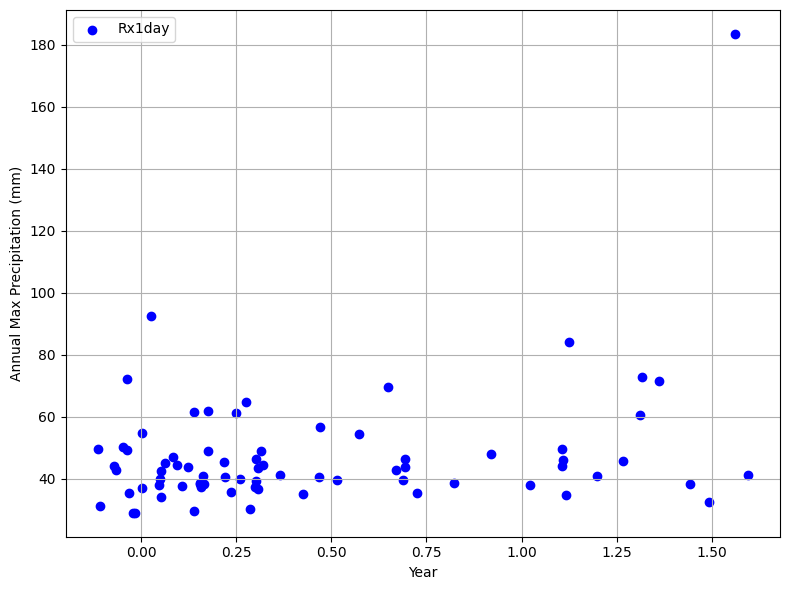

In [10]:
# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(combined_df.tas, combined_df.pr, color='blue', marker = 'o', label='Rx1day')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Annual Max Precipitation (mm)')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()